In [1]:
import time
import os
import logging
from pathlib import Path
import datetime
from config import config
from gpt_model import get_completion_from_gpt
from claude import get_completion_from_claude
from ollama import get_completion_from_ollama
from format_output import Format_output
import pandas as pd
import matplotlib.pyplot as plt
import csv
import ast 
import seaborn as sns
from math import pi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import nltk
from rouge import Rouge
from nltk.metrics import edit_distance
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [2]:
# Set the ROOT_DIR to your repository root.
ROOT_DIR = os.path.dirname(os.path.abspath(''))
# Set the DATA_DIR to the directory where your data resides.
DATA_DIR = os.path.join(ROOT_DIR, 'data/loghub_2k')

In [3]:
save_dir_path = os.path.join(ROOT_DIR, 'results')

now_time = datetime.datetime.now()
date_string = "Semantic_" + now_time.strftime('%Y-%m-%d-%H-%M-%S')
save_dir_separator = "Semantic_" + now_time.strftime('%Y%m%d%H%M%S')

save_dir_now = os.path.join(save_dir_path, save_dir_separator)
raw_save_dir = os.path.join(save_dir_now, "semantic_raw_results/")
Path(raw_save_dir).mkdir(parents=True, exist_ok=True)
semantic_template_file_name = 'semantic_output.txt'
variables_output_file_name = 'variables_output.csv'
semantic_template_output_file_path = raw_save_dir + semantic_template_file_name
variables_output_file_path = raw_save_dir + variables_output_file_name


In [4]:
# File paths
ground_truth_file_path = os.path.join(DATA_DIR, "sample_ground_truth_template.csv")
raw_log_file_path = os.path.join(DATA_DIR, "sample_combined_raw_logs.txt")

In [5]:
# Load raw log messages
with open(raw_log_file_path, 'r') as raw_file:
    raw_logs = [line.strip() for line in raw_file.readlines()]


In [6]:
# Step 1: Reformulate log messages with semantic understanding
counter=0
enhanced_prompts = []
enhanced_prompts_file_path = os.path.join(save_dir_now, "enhanced_prompts.txt")
for raw_log in raw_logs:
    prompt=f"""You are provided with a log message. Your task is to understand and extract the meaning behind the semi-structured log message.
                      
                    Log message: {raw_log}. 

                    A log message usually contains a header that is automatically produced by the logging framework, including information such as timestamp, class, and logging level (INFO, DEBUG, WARN etc.).
                    Ignore all these details and just understand meaning behind the natural languagae text which is in the log content.

                    The log content typically consists of many parts: 
                    1. Template - message body, that contains constant strings (or keywords) describing the system events; 
                    2. Parameters/Variables - dynamic variables, which reflect specific runtime status;

                    Please capture the essential context and meaning from the log message to understand the reasoning behind each raw log.
                    Provide only the meaning in one sentence from each log message surrounded by <TPL> and </TPL> with no empty lines.
                    Never provide any text other than just the understanding from the log message
                """
    
    # enhanced_prompt = get_completion_from_gpt(new_prompt)
    # enhanced_prompt = get_completion_from_claude(new_prompt)
    enhanced_prompt = get_completion_from_ollama(prompt)
    enhanced_prompts.append(enhanced_prompt)
    if counter % 10 == 0:
        print(f'{counter}: {enhanced_prompt}')
    counter+=1    


0: <TPL>The worker environment initialization was successful using the configuration file /etc/httpd/conf/workers2.properties.</TPL>
10: <TPL>The temperature of gige5 interface is 1072878243 and it is a warning.</TPL>
20: <TPL>The command has been aborted.</TPL>
30: <TPL>The system reports that the L2 cache size is 256K.</TPL>
40: <TPL>QQ.exe attempted to connect to tcpconn4.tencent.com:80 via proxy proxy.cse.cuhk.edu.hk:5070 but was unsuccessful because the proxy closed the connection unexpectedly.</TPL>
50: <TPL>The number of snapshots to retain during automatic purging is set to 3.</TPL>
60: <TPL>The RAS kernel has disabled store gathering.</TPL>
70: <TPL>Z coordinate exceeds physical dimension at node map file.</TPL>
80: <TPL>The MapReduce task attempted_1445144423722_0020_m_000000_0 received a shuffle port of 13562 from the ContainerManager.</TPL>
90: <TPL>The specified service did not ship in the requestor's bundle.</TPL>
100: <TPL>The system has detected that a display has been 

In [7]:
print(len(enhanced_prompts))

193


In [8]:
# save and format output data in a csv file
Format_output.save_raw_output(enhanced_prompts_file_path, enhanced_prompts)

# Save all semantic log templates to a file
print(f"Semantic log templates saved to: {enhanced_prompts_file_path}")

Semantic log templates saved to: /Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Semantic_20241204222129/enhanced_prompts.txt


In [9]:
# convert raw output into formatted file 
Format_output.remove_TPL_from_output(enhanced_prompts_file_path, enhanced_prompts_file_path)

Processed output saved to: /Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Semantic_20241204222129/enhanced_prompts.txt


In [10]:
# Step 2: Generate log template using zero-shot learning
counter_1 = 0
semantic_based_templates = []
for raw_log, enhanced_prompt in zip(raw_logs, enhanced_prompts):
    semantic_prompt = f"""You will be provided with a log message delimited by <MSG> and </MSG>. 
    You are also provided with the meaning or understanding from the log message as follow: {enhanced_prompt}. 
    
    The log message typically consists of two parts: 
    1. Template - message body, that contains constant strings (or keywords) describing the system events; 
    2. Parameters/Variables - dynamic variables, which reflect specific runtime status.
    You must identify and abstract all the dynamic variables in the log message with suitable placeholders inside angle brackets to extract the corresponding template.
    You must output the template corresponding to the log message. Print only the input log's template surrounded by <TPL> and </TPL>. 
    Never print an explanation of how the template is constructed.
    Here are a few examples of log messages (labeled with Q:) and corresponding templates (labeled with A:):

    Q: <MSG>[081109 204453 34 INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.250.11.85:50010 is added to blk_2377150260128098806 size 67108864]</MSG>
    A: <TPL>[BLOCK* NameSystem.addStoredBlock: blockMap updated: <*>:<*> is added to <*> size <*>]</TPL>

    Q: <MSG>- 1129734520 2005.10.19 R17-M0-N0-I:J18-U01 2005-10-19-08.08.40.058960 R17-M0-N0-I:J18-U01 RAS KERNEL INFO shutdown complete</MSG>
    A: <TPL>shutdown complete</TPL>

    Q: <MSG>20231114T101914E ERROR 14 while processing line 123: cannot find input '42'</MSG>
    A: <TPL>ERROR <*> while processing line <*>: cannot find input <*></TPL>

    Q: <MSG>2023-01-14 23:05:14 INFO: Reading data from /user/input/file.txt</MSG>
    A: <TPL>Reading data from <*> </TPL>
    Here is the input log message: <MSG>{raw_log}</MSG>
    Please print the corresponding template.
    """
    # response = get_completion_from_gpt(semantic_prompt)
    # response = get_completion_from_claude(semantic_prompt)
    response = get_completion_from_ollama(semantic_prompt)
    semantic_based_templates.append(response)
    
    if counter_1 % 10 == 0:
        print(f'{counter_1}: {response}')
        
    counter_1+=1   
   
print(len(semantic_based_templates))


0: <TPL>[<*> [<*>] <*> /etc/httpd/conf/<*></TPL>
10: <TPL><*> <* interface temperature <*> <*> warning</TPL>
20: <TPL>Command has been aborted</TPL>
30: <TPL>CPU: L2 cache: <*> </TPL>
40: <TPL>QQ.exe - <*> error : Could not connect through proxy <*> - Proxy closed the connection unexpectedly.</TPL>
50: <TPL>autopurge.snapRetainCount set to <*> </TPL>
60: <TPL>disable store gathering..................*</TPL>
70: <TPL>ciod: Z coordinate <*> exceeds physical dimension <*> at line <*> of node map file <*> </TPL>
80: <TPL>Shuffle port returned by ContainerManager for <*> : <*> </TPL>
90: <TPL>Path not allowed in target domain: type = pid, path = <*> error = 147: The specified service did not ship in the requestor's bundle, origin = <*> </TPL>
100: <TPL>CGXDisplayDidWakeNotification [<*>]: posting <*> </TPL>
110: <TPL>insertHiHealthData() bulkSaveDetailHiHealthData fail errorCode = <*>,errorMessage = <*> </TPL>
120: <TPL>Received disconnect from <*>: <*> [preauth]</TPL>
130: <TPL>PAM <*> mor

In [11]:
# save and format output data in a csv file
Format_output.save_raw_output(semantic_template_output_file_path, semantic_based_templates)
# convert raw output into formatted file 
Format_output.remove_TPL_from_output(semantic_template_output_file_path, semantic_template_output_file_path)
print(f"Semantic Log templates are saved to: {semantic_template_output_file_path}")

Processed output saved to: /Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Semantic_20241204222129/semantic_raw_results/semantic_output.txt
Semantic Log templates are saved to: /Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Semantic_20241204222129/semantic_raw_results/semantic_output.txt


In [12]:
# File paths
processed_log_template_file_path = semantic_template_output_file_path

# Load ground truth data
ground_truth_df = pd.read_csv(ground_truth_file_path)
ground_truth_log_templates = ground_truth_df['EventTemplate'].tolist()
ground_truth_systems = ground_truth_df['System'].tolist()

# Load processed output data
with open(processed_log_template_file_path, 'r') as processed_file:
    processed_log_templates = [line.strip() for line in processed_file.readlines()]
 

# Ensure the lists are of the same length for comparison
min_length = min(len(ground_truth_log_templates), len(processed_log_templates))
ground_truth_log_templates = ground_truth_log_templates[:min_length]
processed_log_templates = processed_log_templates[:min_length]
ground_truth_systems = ground_truth_systems[:min_length]

# Calculate evaluation metrics for processed_log_templates
accuracy = accuracy_score(ground_truth_log_templates, processed_log_templates)
precision = precision_score(ground_truth_log_templates, processed_log_templates, average='weighted', zero_division=0)
recall = recall_score(ground_truth_log_templates, processed_log_templates, average='weighted', zero_division=0)
f1 = f1_score(ground_truth_log_templates, processed_log_templates, average='weighted', zero_division=0)

# Print evaluation metrics for processed_log_templates
print(f"Log Template Parsing Accuracy: {accuracy * 100:.2f}%")
print(f"Log Template Precision: {precision * 100:.2f}%")
print(f"Log Template Recall: {recall * 100:.2f}%")
print(f"Log Template F1 Score: {f1 * 100:.2f}%")



Log Template Parsing Accuracy: 27.46%
Log Template Precision: 27.20%
Log Template Recall: 27.46%
Log Template F1 Score: 27.29%


In [13]:
# Calculate correctly parsed log templates for each system
correct_parsed_counts = {}
for system, gt_template, processed_template in zip(ground_truth_systems, ground_truth_log_templates, processed_log_templates):
    if gt_template == processed_template:
        if system not in correct_parsed_counts:
            correct_parsed_counts[system] = 0
        correct_parsed_counts[system] += 1

# Print correctly parsed log templates for each system
print("\nCorrectly Parsed Log Templates per System:")
total=0
for system, count in correct_parsed_counts.items():
    total +=count
    print(f"{system}: {count}")

print(f"Total correctly parsed log templates: {total}")


Correctly Parsed Log Templates per System:
Apache: 3
HPC: 1
Linux: 7
Zookeeper: 5
BGL: 5
Hadoop: 5
Mac: 1
HealthApp: 5
OpenSSH: 3
Spark: 7
HDFS: 4
OpenStack: 5
Thunderbird: 2
Total correctly parsed log templates: 53


In [14]:
# Ensure that NLTK and other required libraries are installed
nltk.download('punkt')

# 1. Edit Distance for Each System
def calculate_edit_distance_for_each_system(ground_truth_list, processed_list, system_list):
    system_distances = {}
    for system, gt, processed in zip(system_list, ground_truth_list, processed_list):
        distance = edit_distance(gt, processed)
        if system not in system_distances:
            system_distances[system] = []
        system_distances[system].append(distance)
    
    avg_distances = {}
    print("\nAverage Edit Distance Range: 0 to infinity, where lower is better")
    for system, distances in system_distances.items():
        avg_distance = sum(distances) / len(distances)
        avg_distances[system] = avg_distance
        print(f"System '{system}':              Average Edit Distance = {avg_distance:.2f}")
    
    return avg_distances

# 2. ROUGE-L Score for Each System
def calculate_rouge_l_for_each_system(ground_truth_list, processed_list, system_list):
    rouge = Rouge()
    system_rouge_scores = {}
    for system, gt, processed in zip(system_list, ground_truth_list, processed_list):
        scores = rouge.get_scores(processed, gt, avg=True)
        rouge_l_score = scores['rouge-l']['f']
        if system not in system_rouge_scores:
            system_rouge_scores[system] = []
        system_rouge_scores[system].append(rouge_l_score)
    
    avg_rouge_scores = {}
    print("\nAverage ROUGE-L Score Range: 0 to 1, where 1 means highly similar")
    for system, rouge_scores in system_rouge_scores.items():
        avg_rouge_score = sum(rouge_scores) / len(rouge_scores)
        avg_rouge_scores[system] = avg_rouge_score
        print(f"System '{system}':              Average ROUGE-L Score = {avg_rouge_score:.2f}")
    
    return avg_rouge_scores

# Calculating metrics for the given log templates
print("Comparing the processed log templates to the ground truth log templates:\n")
edit_distances = calculate_edit_distance_for_each_system(ground_truth_log_templates, processed_log_templates, ground_truth_systems)
rouge_l_scores = calculate_rouge_l_for_each_system(ground_truth_log_templates, processed_log_templates, ground_truth_systems)



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/navneetsharma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Comparing the processed log templates to the ground truth log templates:


Average Edit Distance Range: 0 to infinity, where lower is better
System 'Apache':              Average Edit Distance = 8.83
System 'HPC':              Average Edit Distance = 26.20
System 'Linux':              Average Edit Distance = 4.00
System 'Proxifier':              Average Edit Distance = 21.12
System 'Zookeeper':              Average Edit Distance = 15.93
System 'BGL':              Average Edit Distance = 9.20
System 'Hadoop':              Average Edit Distance = 10.20
System 'Mac':              Average Edit Distance = 30.33
System 'HealthApp':              Average Edit Distance = 10.00
System 'OpenSSH':              Average Edit Distance = 20.13
System 'Spark':              Average Edit Distance = 10.93
System 'HDFS':              Average Edit Distance = 4.64
System 'OpenStack':              Average Edit Distance = 22.67
System 'Thunderbird':              Average Edit Distance = 14.07

Average ROUGE-L S

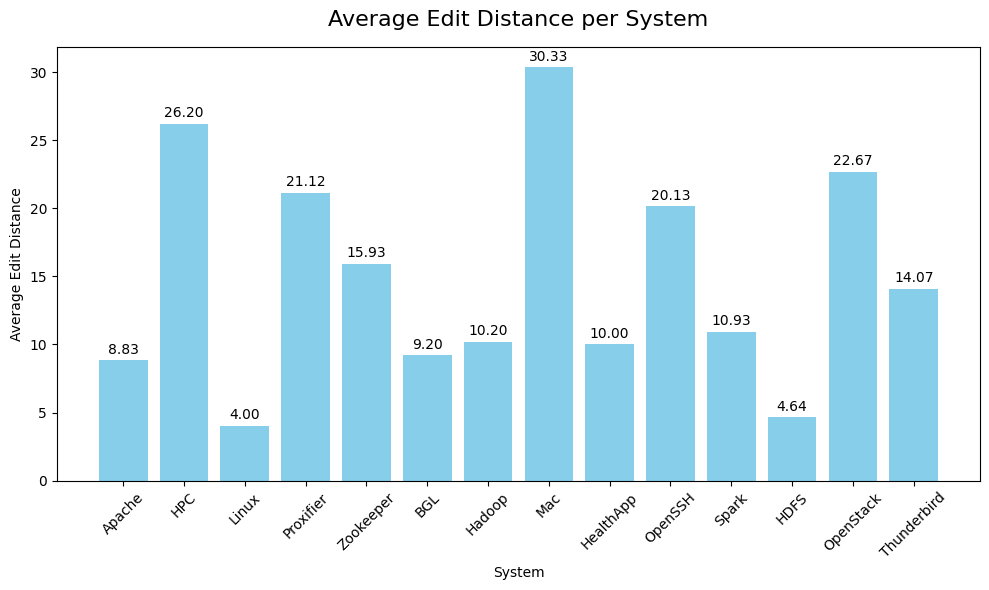

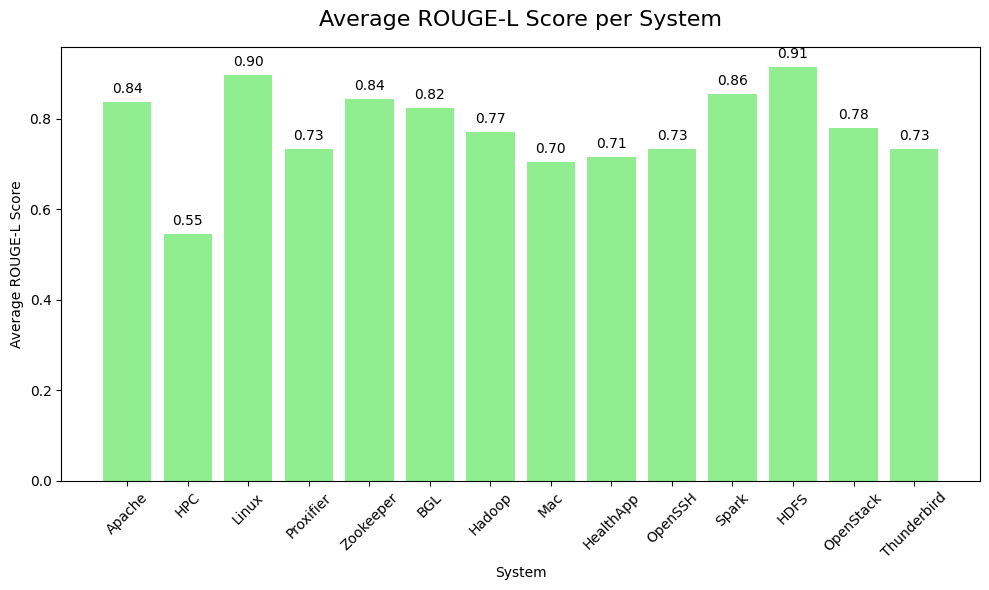

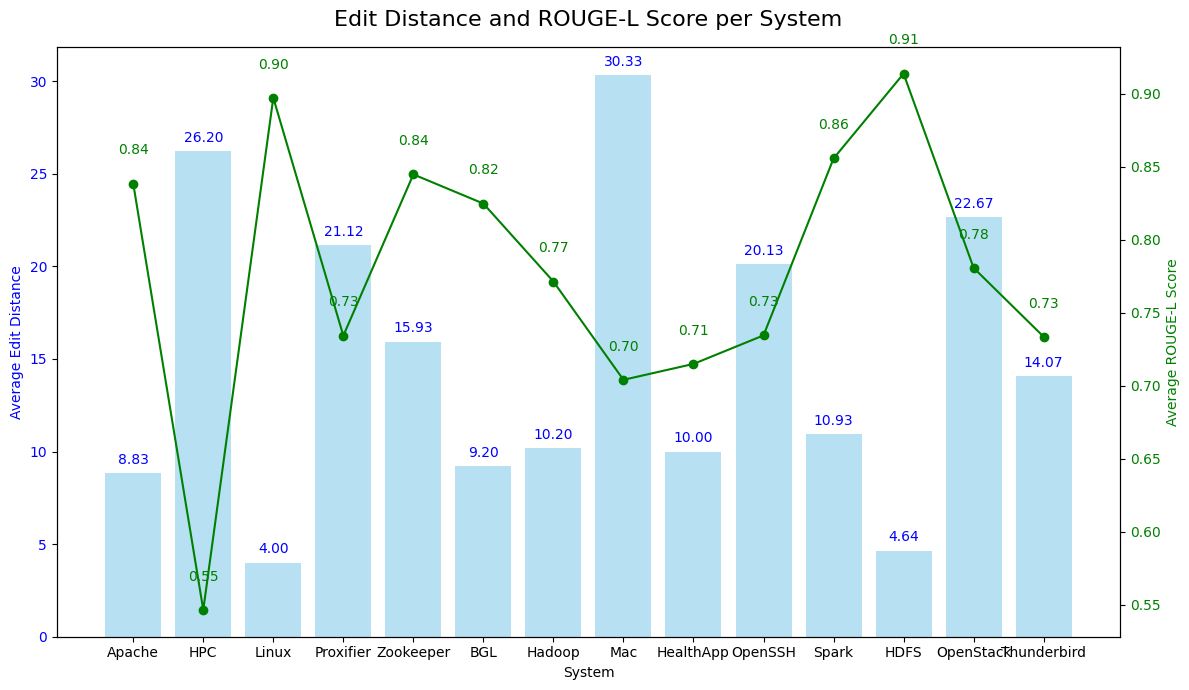

In [15]:
output_directory = os.path.dirname(processed_log_template_file_path)

# 3. Visualizations
def create_visualizations(edit_distances, rouge_l_scores, output_directory):
    systems = list(edit_distances.keys())
    edit_values = list(edit_distances.values())
    rouge_values = list(rouge_l_scores.values())

    # Edit Distance Bar Plot
    plt.figure(figsize=(10, 6))
    plt.bar(systems, edit_values, color='skyblue')
    plt.xlabel('System')
    plt.ylabel('Average Edit Distance')
    plt.title('Average Edit Distance per System', fontsize=16, fontweight='normal', pad=15)
    plt.xticks(rotation=45)
    for i, value in enumerate(edit_values):
        plt.text(i, value + 0.5, f'{value:.2f}', ha='center')
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, 'edit_distance_per_system.png'))
    plt.show()
    plt.close()

    # ROUGE-L Score Bar Plot
    plt.figure(figsize=(10, 6))
    plt.bar(systems, rouge_values, color='lightgreen')
    plt.xlabel('System')
    plt.ylabel('Average ROUGE-L Score')
    plt.title('Average ROUGE-L Score per System', fontsize=16, fontweight='normal', pad=15)
    plt.xticks(rotation=45)
    for i, value in enumerate(rouge_values):
        plt.text(i, value + 0.02, f'{value:.2f}', ha='center')
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, 'rouge_l_score_per_system.png'))
    plt.show()
    plt.close()

    # Combined Edit Distance and ROUGE-L Score Bar Plot
    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax1.bar(systems, edit_values, color='skyblue', alpha=0.6, label='Edit Distance')
    ax1.set_xlabel('System')
    ax1.set_ylabel('Average Edit Distance', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    for i, value in enumerate(edit_values):
        ax1.text(i, value + 0.5, f'{value:.2f}', ha='center', color='blue')
    
    ax2 = ax1.twinx()
    ax2.plot(systems, rouge_values, color='green', marker='o', linestyle='-', label='ROUGE-L Score')
    ax2.set_ylabel('Average ROUGE-L Score', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    for i, value in enumerate(rouge_values):
        ax2.text(i, value + 0.02, f'{value:.2f}', ha='center', color='green')
    
    plt.title('Edit Distance and ROUGE-L Score per System', fontsize=16, fontweight='normal', pad=15)
    fig.tight_layout()
    plt.xticks(rotation=45)
    plt.savefig(os.path.join(output_directory, 'combined_scores_per_system.png'))
    plt.show()
    plt.close()

# Create and save visualizations
create_visualizations(edit_distances, rouge_l_scores, output_directory)


In [ ]:
counter_1 = 0
variable_count_from_logs = []
for raw_log, enhanced_prompt in zip(raw_logs, enhanced_prompts):
    semantic_prompt = f"""You will be provided with a log message delimited by <MSG> and </MSG>. 
    You are also provided with the meaning or understanding from the log message as follows: {enhanced_prompt}. 
    
    I want you to categorize the variable(s) in each log message as a dictionary with each variable category as the key and the count of occurrences of that category as the value. 
    The variable should be classified within the categories as below:
    1. Object ID [OID]	Identification information of an object
    2. Location Indicator   [LOI]	Location information of an object
    3. Object Name	[OBN]	Name of an object
    4. Type Indicator	[TID]	Type information of an object or an action
    5. Switch Indicator	[SID]	Status of a switch variable
    6. Time or Duration of an Action	[TDA]	Time or duration of an action
    7. Computing Resources	[CRS]	Information of computing resource
    8. Object Amount	[OBA]	Amount of an object
    9. Status Code	[STC]	Status code of an object or an action
    10. Other Parameters	[OTP]	Other information that does not belong to the above categories

    Here is the input log message: <MSG>{raw_log}</MSG>
    
    Please generate a dictionary where each key represents one of the categories listed above and the value represents the count of occurrences of that category in the log message. 
    Only include categories that are present in the log message and do not print anything other than the dictionary. Never print the full name for categories just the code like "OID":2, etc.

    Example of the format:
    {{
        "OID": 2,
        "LOI": 1,
        "STC": 1
    }}
    """
    
    # response = get_completion_from_gpt(semantic_prompt)
    # response = get_completion_from_claude(semantic_prompt)
    response = get_completion_from_ollama(semantic_prompt)
    variable_count_from_logs.append(response)    

    if counter_1 % 10 == 0:
        print(f'{counter_1}: {response}')
        
    counter_1 += 1

print(len(variable_count_from_logs))

0: {
    "TID": 1,
    "CRS": 1,
    "OTP": 1
}
10: {
    "OBN": 1,
    "TDA": 1,
    "OTP": 1
}
20: {
    "TID": 1,
    "STC": 1
}
30: {
    "CRS": 1
}
40: {
    "OBN": 1,
    "LOI": 1,
    "TID": 1,
    "SID": 1,
    "OTP": 1
}


In [ ]:
# save and format output data in a csv file
Format_output.save_raw_output(variables_output_file_path, variable_count_from_logs)

fieldnames = ['Index', 'OID', 'LOI', 'OBN', 'TID', 'SID', 'TDA', 'CRS', 'OBA', 'STC', 'OTP']

# Writing the data to the CSV
with open(variables_output_file_path, mode='w', newline='') as variable_file:
    writer = csv.DictWriter(variable_file, fieldnames=fieldnames)
    
    # Write header
    writer.writeheader()
    
    # Write each row of the dictionary results
    for index, log_dict in enumerate(variable_count_from_logs):
        # Convert response (string) to a dictionary if necessary
        if isinstance(log_dict, str):
            try:
                log_dict = ast.literal_eval(log_dict)  # Safely convert string to dict
            except (SyntaxError, ValueError) as e:
                print(f"Error parsing log_dict at index {index}: {e}")
                log_dict = {key: 0 for key in fieldnames[1:]}  # Set all values to 0 for this row to keep the order

        # Ensure that all keys are present, with missing ones having a value of 0
        row_data = {key: log_dict.get(key, 0) for key in fieldnames[1:]}
        row_data['Index'] = index + 1
        writer.writerow(row_data)

# Save all variables to a file
print(f"Variables are saved to: {variables_output_file_path}")

In [ ]:
# Load ground truth and processed data
ground_truth_df = pd.read_csv(ground_truth_file_path)
processed_df = pd.read_csv(variables_output_file_path)

# Ensure the dataframes are of the same length for comparison
min_length = min(len(ground_truth_df), len(processed_df))
ground_truth_df = ground_truth_df[:min_length]
processed_df = processed_df[:min_length]

# 1. Per Log Message Evaluation (Overall Accuracy per Log)
log_message_accuracies = []
for idx in range(min_length):
    ground_truth_row = ground_truth_df.iloc[idx, 2:]  # Skip 'Index' column
    processed_row = processed_df.iloc[idx, 1:]        # Skip 'Index' column
    accuracy = (ground_truth_row == processed_row).mean()
    log_message_accuracies.append(accuracy)

overall_log_accuracy = sum(log_message_accuracies) / len(log_message_accuracies)
print(f"Overall Log Message Accuracy: {overall_log_accuracy * 100:.2f}%")

# 2. Evaluation Per Variable Type (Precision, Recall, F1 Score, and Accuracy for each variable type)
variable_types = ['OID', 'LOI', 'OBN', 'TID', 'SID', 'TDA', 'CRS', 'OBA', 'STC', 'OTP']
precision_scores = {}
recall_scores = {}
f1_scores = {}
accuracy_scores = {}

for var in variable_types:
    y_true = ground_truth_df[var]
    y_pred = processed_df[var]
    
    precision_scores[var] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_scores[var] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_scores[var] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    accuracy_scores[var] = accuracy_score(y_true, y_pred)

# Print Per Variable Type Metrics
print("\nEvaluation Per Variable Type:")
for var in variable_types:
    print(f"{var}:")
    print(f"  Precision: {precision_scores[var] * 100:.2f}%")
    print(f"  Recall: {recall_scores[var] * 100:.2f}%")
    print(f"  F1 Score: {f1_scores[var] * 100:.2f}%")
    print(f"  Accuracy: {accuracy_scores[var] * 100:.2f}%")

# 3. Overall Evaluation for All Variables
ground_truth_flat = ground_truth_df[variable_types].values.flatten()
processed_flat = processed_df[variable_types].values.flatten()

overall_precision = precision_score(ground_truth_flat, processed_flat, average='weighted', zero_division=0)
overall_recall = recall_score(ground_truth_flat, processed_flat, average='weighted', zero_division=0)
overall_f1 = f1_score(ground_truth_flat, processed_flat, average='weighted', zero_division=0)
overall_accuracy = accuracy_score(ground_truth_flat, processed_flat)

# Print Overall Metrics
print("\nOverall Evaluation for All Variables:")
print(f"Overall Precision: {overall_precision * 100:.2f}%")
print(f"Overall Recall: {overall_recall * 100:.2f}%")
print(f"Overall F1 Score: {overall_f1 * 100:.2f}%")

print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

In [ ]:
# Add the calculated accuracies to the ground truth DataFrame
ground_truth_df['Accuracy'] = log_message_accuracies

# Group by 'System' and calculate average accuracy per system
system_wise_accuracy = ground_truth_df.groupby('System')['Accuracy'].mean()

# Normalize accuracy values for color mapping
norm = mcolors.Normalize(vmin=system_wise_accuracy.min(), vmax=system_wise_accuracy.max())
colors = [cm.Blues(norm(value)) for value in system_wise_accuracy.values]

# Plotting System-wise Average Accuracies
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=system_wise_accuracy.index, y=system_wise_accuracy.values, palette="Blues")

# Assign color to each bar manually to follow the computed color based on accuracy values
for bar, color in zip(ax.patches, colors):
    bar.set_facecolor(color)

# Add title and labels
plt.title('System-wise Average Accuracy', fontsize=16, fontweight='normal', pad=15)
plt.xlabel('System')
plt.ylabel('Average Accuracy')
plt.ylim(0, 1)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100:.2f}%', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

# Save the plot
plt.savefig(os.path.join(output_directory, 'system_wise_average_accuracy.png'), bbox_inches='tight')

plt.show()

In [ ]:
# 2. Per Variable Type Accuracy Comparison with Data Labels
plt.figure(figsize=(12, 6))

# Set color manually using a color map rather than using the deprecated palette without hue
colors = sns.color_palette('Blues', len(accuracy_scores))
ax = sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), palette=colors)

# Add data labels on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100:.2f}%', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.title('Per Variable Type Accuracy Comparison', fontsize=16, fontweight='normal', pad=15)
plt.xlabel('Variable Type')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Save the plot before showing it
plt.savefig(os.path.join(output_directory, 'per_variable_type_accuracy_comparison.png'), bbox_inches='tight')

plt.show()

In [ ]:
# 3. Overall Precision, Recall, F1 Score, and Accuracy (Radar Chart)
overall_metrics = {'Precision': overall_precision, 'Recall': overall_recall, 'F1 Score': overall_f1, 'Accuracy': overall_accuracy}  # Replace with actual overall metrics
categories = list(overall_metrics.keys())
values = list(overall_metrics.values())
# Plotting Overall Metrics Using a Grouped Bar Chart
plt.figure(figsize=(12, 8))
bars = plt.bar(categories, values, color='skyblue', edgecolor='black')

# Set title and labels
plt.title('Overall Metrics Comparison', fontsize=16, fontweight='normal', pad=15)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add data labels on each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
             f'{bar.get_height() * 100:.2f}%', ha='center', va='bottom', fontsize=12, color='black')

# Save the plot
output_file_path = os.path.join(output_directory, 'overall_metrics_comparison_bar_chart.png')
plt.savefig(output_file_path, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# 4. Distribution of Log Message Accuracies
plt.figure(figsize=(12, 6))
sns.histplot(log_message_accuracies, bins=10, kde=True)
plt.title('Distribution of Log Message Accuracies', fontsize=16, fontweight='normal', pad=15)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')

# Save the plot
output_file_path = os.path.join(output_directory, 'distribution_of_log_message_accuracies.png')
plt.savefig(output_file_path, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
# 5.Box Plot of Metrics Per Variable Type
metrics_all = pd.DataFrame({'Precision': list(precision_scores.values()),
                            'Recall': list(recall_scores.values()),
                            'F1 Score': list(f1_scores.values()),
                            'Accuracy': list(accuracy_scores.values())}, index=variable_types)
plt.figure(figsize=(14, 8))
ax = sns.boxplot(data=metrics_all)

# Add median value labels on each box
medians = metrics_all.median()

for i, median in enumerate(medians):
    ax.text(i, median, f'{median:.2f}', horizontalalignment='center', fontweight='bold', color='black', size=10)

plt.title('Box Plot of Metrics per Variable Type', fontsize=16, fontweight='normal', pad=15)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)
# Save the plot before showing it
plt.savefig(os.path.join(output_directory, 'box_plot_of_metrics_per_tariable_type.png'), bbox_inches='tight')

plt.show()


In [ ]:
# 6. Cumulative Distribution of Log Accuracy
cumulative_accuracies = np.cumsum(log_message_accuracies) / np.arange(1, len(log_message_accuracies) + 1)
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_accuracies) + 1), cumulative_accuracies, marker='o')
plt.title('Cumulative Distribution of Log Accuracies')
plt.xlabel('Log Index')
plt.ylabel('Cumulative Accuracy')
plt.grid(True)
plt.show()